# Agentic Customer Segmentation for Targeted Marketing
Build a segmentation pipeline and a local LLM-backed agent that explains clusters, retrieves grounding docs, and drafts targeted messages.

In [1]:
import numpy as np
import pandas as pd

def generate_insurance_dataset_realistic_v4(
    n_customers: int = 5000,
    start_date: str = "2020-01-01",
    end_date: str = "2024-12-31",
    seed: int = 42,
    correlation_strength: float = 0.6,
    return_metadata: bool = False,
    adaptive_noise: bool = True,
    base_std: float = 0.05,
    strength: float = 0.08
) -> pd.DataFrame:
    """
    Version 4 — Realistic Synthetic Insurance Dataset Generator with Adaptive Noise
    
    ✅ Enhancements over v3:
    - Integrated adaptive behavioral noise based on income and age
    - Slightly more realistic renewal/churn variation by customer profile
    - Optional automatic saving and metadata return
    """

    rng = np.random.default_rng(seed)
    correlation_strength = np.clip(correlation_strength, 0.0, 0.95)
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)

    # --- 1. Demographics (age–income correlation)
    mean = [0, 0]
    cov = [[1, correlation_strength], [correlation_strength, 1]]
    z_age, z_income = rng.multivariate_normal(mean, cov, n_customers).T

    ages = np.clip((z_age * 12 + 45).astype(int), 18, 85)
    income_levels = np.exp(z_income * 0.3) * (25000 + 600 * ages)
    income_levels *= rng.lognormal(0, 0.2, n_customers)
    income_levels = np.clip(income_levels, 20000, 250000)

    genders = rng.choice(["M", "F"], n_customers, p=[0.52, 0.48])
    regions = rng.choice(["Urban", "Suburban", "Rural"], n_customers, p=[0.4, 0.45, 0.15])

    # --- 2. Policy Type (income-driven probability)
    income_scaled = (income_levels - income_levels.min()) / (income_levels.max() - income_levels.min())
    policy_probs = np.vstack([
        np.clip([
            0.55 - 0.10 * income_scaled,
            0.25 + 0.10 * income_scaled,
            0.10 + 0.08 * income_scaled,
            np.full_like(income_scaled, 0.10)
        ], 0, None).T for _ in range(1)
    ]).reshape(n_customers, 4)
    policy_probs /= policy_probs.sum(axis=1, keepdims=True)
    policy_types = np.array(["Auto", "Home", "Life", "Health"])
    chosen_policy = [rng.choice(policy_types, p=p) for p in policy_probs]

    # --- 3. Premium Amounts (policy + income)
    base_premiums = {"Auto": 800, "Home": 1600, "Life": 2000, "Health": 1200}
    premium_base = np.array([base_premiums[p] for p in chosen_policy])
    premium_amount = premium_base * (1 + np.sqrt(income_levels / 150000) * 0.5)
    premium_amount *= rng.lognormal(0, 0.25, n_customers)
    premium_amount = np.clip(premium_amount, 300, 10000)

    # --- 4. Policy tenure
    tenure_months = np.clip(rng.exponential(30, n_customers), 3, 84)
    tenure_days = (tenure_months * 30).astype(int)
    valid_start_days = np.maximum(1, (end - start).days - tenure_days)
    start_offsets = rng.integers(0, valid_start_days, n_customers)
    policy_start_dates = start + pd.to_timedelta(start_offsets, unit="D")
    policy_end_dates = policy_start_dates + pd.to_timedelta(tenure_days, unit="D")
    policy_end_dates = policy_end_dates.where(policy_end_dates <= pd.Timestamp(end), pd.Timestamp(end))

    # --- 5. Payment behavior
    payment_freq = rng.choice(["Monthly", "Quarterly", "Annual"], n_customers, p=[0.6, 0.25, 0.15])
    payment_regularity = np.clip(rng.beta(4, 1.5, n_customers) + rng.normal(0, 0.05, n_customers), 0.3, 1.0)

    # --- 6. Claims (depends on age + policy)
    base_claim_rate = np.where(ages < 25, 0.25, np.where(ages > 65, 0.18, 0.1))
    policy_factor = np.array([{"Auto":1.4, "Home":0.8, "Life":0.6, "Health":1.0}[p] for p in chosen_policy])
    claim_lambda = base_claim_rate * policy_factor * np.sqrt(tenure_months / 12)
    num_claims = np.clip(rng.poisson(claim_lambda), 0, 15)

    # Claim costs — lognormal by policy type
    claim_cost_params = {"Auto": (7.8, 0.9), "Home": (8.3, 0.8), "Life": (9.0, 0.6), "Health": (8.0, 1.0)}
    claim_costs = np.zeros(n_customers)
    for p, (mean, sigma) in claim_cost_params.items():
        idx = np.array(chosen_policy) == p
        claim_costs[idx] = num_claims[idx] * rng.lognormal(mean, sigma, idx.sum())

    # --- 7. Renewal probability (with adaptive noise)
    logits = (
        -0.02 * (ages - 45)
        - 0.3 * num_claims
        + 1.0 * payment_regularity
        + 0.004 * tenure_months
        + rng.normal(0, 0.5, n_customers)
    )
    renewal_prob = 1 / (1 + np.exp(-logits))
    renewal_prob = np.clip(renewal_prob, 0.05, 0.95)

    # 🔹 Adaptive noise based on age & income
    if adaptive_noise:
        income_norm = (income_levels - income_levels.min()) / (income_levels.max() - income_levels.min())
        age_norm = (ages - ages.min()) / (ages.max() - ages.min())

        # Stable customers: older + higher income
        stability_score = (income_norm + age_norm) / 2
        noise_std = base_std + strength * (1 - stability_score)

        adaptive_noise = rng.normal(0, noise_std)
        renewal_prob = np.clip(renewal_prob + adaptive_noise, 0.01, 0.99)

    churned = rng.binomial(1, 1 - renewal_prob)

    # --- 8. Last claim date
    has_claims = num_claims > 0
    last_claim_date = np.full(n_customers, np.datetime64("NaT"), dtype="datetime64[ns]")
    random_offsets = rng.exponential(180, has_claims.sum()).astype(int)
    temp_dates = policy_end_dates[has_claims] - pd.to_timedelta(random_offsets, unit="D")
    temp_dates = np.maximum(temp_dates.values.astype("datetime64[D]"), policy_start_dates[has_claims].values.astype("datetime64[D]"))
    last_claim_date[has_claims] = temp_dates

    # --- 9. Lifetime Value (LTV)
    expected_value = premium_amount * (tenure_months / 12)
    claim_penalty = np.minimum(claim_costs / (expected_value + 1e-6), 0.8)
    ltv = expected_value * (1 - claim_penalty) * (0.8 + 0.4 * renewal_prob)
    ltv[churned == 1] *= rng.uniform(0.4, 0.8, churned.sum())
    ltv = np.clip(ltv, 0, 250_000)

    # --- 10. Derived temporal features
    policy_age_days = (policy_end_dates - policy_start_dates).days
    days_since_last_claim = (policy_end_dates - last_claim_date).days.astype(float).to_numpy()
    days_since_last_claim[~has_claims] = np.nan
    is_active = (policy_end_dates >= end).astype(int)

    # --- 11. Final DataFrame
    df = pd.DataFrame({
        "customer_id": [f"CUST_{i:05d}" for i in range(1, n_customers + 1)],
        "age": ages,
        "gender": genders,
        "region": regions,
        "income_level": np.round(income_levels, 2),
        "policy_type": chosen_policy,
        "premium_amount": np.round(premium_amount, 2),
        "payment_frequency": payment_freq,
        "payment_regularity": np.round(payment_regularity, 3),
        "tenure_months": np.round(tenure_months, 1),
        "num_claims": num_claims,
        "claim_costs": np.round(claim_costs, 2),
        "policy_start_date": policy_start_dates,
        "policy_end_date": policy_end_dates,
        "last_claim_date": pd.to_datetime(last_claim_date),
        "renewal_probability": np.round(renewal_prob, 3),
        "churned": churned,
        "customer_ltv": np.round(ltv, 2),
        "policy_age_days": policy_age_days,
        "days_since_last_claim": days_since_last_claim,
        "is_active": is_active,
    })

    if return_metadata:
        metadata = {
            "n_customers": n_customers,
            "start_date": start_date,
            "end_date": end_date,
            "seed": seed,
            "correlation_strength": correlation_strength,
            "adaptive_noise": adaptive_noise,
            "generated_on": pd.Timestamp.now().isoformat(),
        }
        return df, metadata

    return df

In [2]:
def augment_with_engagement_and_flags_v3(df: pd.DataFrame, seed: int = 42) -> pd.DataFrame:
    """
    ✅ Version 3 — Realistic augmentation of insurance dataset with engagement, delinquency, and risk flags.
    
    Key improvements:
    - No leakage from churn/renewal into behavior features.
    - Behavioral realism: digital users (younger, urban, higher income) show more engagement.
    - Payment and claim behaviors influence risk/delinquency flags probabilistically.
    - Adds derived scores and flags used for segmentation.
    """

    rng = np.random.default_rng(seed)
    df = df.copy()

    # --- 1. Engagement behavior (portal logins, calls, emails)
    # Digital affinity by region & age
    digital_affinity = (
        0.6 * (df["region"] == "Urban").astype(float)
        + 0.3 * (df["region"] == "Suburban").astype(float)
        + 0.1 * (df["region"] == "Rural").astype(float)
    )
    digital_affinity *= np.clip((70 - df["age"]) / 40, 0, 1)  # Younger = more digital
    digital_affinity *= np.clip(np.log1p(df["income_level"]) / np.log(150_000), 0.6, 1.2)

    # Engagement base (mean ~ digital_affinity × tenure)
    base_logins = 3 + 15 * digital_affinity + 0.05 * df["tenure_months"]
    portal_logins = np.clip(rng.normal(base_logins, 2), 0, None).astype(int)

    # Support calls (older + rural → more)
    support_calls = np.clip(
        rng.poisson(1 + 0.015 * (df["age"] - 30) + 1.5 * (df["region"] == "Rural").astype(int)),
        0,
        15,
    )

    # Emails opened (proportional to digital use)
    emails_opened = np.clip(rng.poisson(10 * digital_affinity + 2), 0, 50)

    # --- 2. Payment delinquency
    base_delinquency_prob = (
        0.04 + 0.08 * (df["payment_regularity"] < 0.8).astype(float)
        + 0.03 * (df["income_level"] < 40_000).astype(float)
        + 0.02 * (df["policy_type"] == "Auto").astype(float)
    )
    delinquency_count = rng.binomial(n=3, p=np.clip(base_delinquency_prob, 0, 0.8))

    # --- 3. Engagement score (normalized composite)
    max_portal, max_emails, max_calls = (
        portal_logins.max(),
        emails_opened.max(),
        support_calls.max(),
    )
    engagement_score = (
        0.5 * (portal_logins / (max_portal + 1e-5))
        + 0.3 * (emails_opened / (max_emails + 1e-5))
        + 0.2 * (1 - support_calls / (max_calls + 1e-5))
    )
    engagement_score = np.clip(engagement_score, 0, 1)

    # --- 4. Risk flags (no leakage)
    # High claim frequency/severity → high risk
    claim_freq_flag = (df["num_claims"] > 3).astype(int)
    high_claim_cost_flag = (df["claim_costs"] > df["claim_costs"].median() * 2).astype(int)

    # Financial risk from delinquency
    payment_risk_flag = (delinquency_count >= 2).astype(int)

    # Behavior risk (low engagement)
    low_engagement_flag = (engagement_score < 0.3).astype(int)

    # --- 5. Lifecycle and product mix
    # Simple heuristic: stage inferred from tenure
    lifecycle_stage = pd.cut(
        df["tenure_months"],
        bins=[0, 12, 36, 72, np.inf],
        labels=["New", "Growth", "Mature", "Legacy"],
        right=False,
    )

    # Product mix: probability of having another product (income + engagement)
    multi_policy_prob = np.clip(0.1 + 0.001 * (df["income_level"] / 1000) + 0.3 * engagement_score, 0, 0.9)
    multi_policy_flag = rng.binomial(1, multi_policy_prob)

    # --- 6. Engagement trends (rolling proxy)
    recent_logins_3m = np.clip(
        (portal_logins * rng.uniform(0.6, 1.0, len(df))).astype(int),
        0,
        portal_logins,
    )
    engagement_trend = np.where(
        recent_logins_3m > (0.8 * portal_logins), "Up",
        np.where(recent_logins_3m < (0.5 * portal_logins), "Down", "Stable")
    )

    # --- 7. Add all columns
    df["portal_logins"] = portal_logins
    df["support_calls"] = support_calls
    df["emails_opened"] = emails_opened
    df["delinquency_count"] = delinquency_count
    df["engagement_score"] = np.round(engagement_score, 3)
    df["claim_freq_flag"] = claim_freq_flag
    df["high_claim_cost_flag"] = high_claim_cost_flag
    df["payment_risk_flag"] = payment_risk_flag
    df["low_engagement_flag"] = low_engagement_flag
    df["multi_policy_flag"] = multi_policy_flag
    df["lifecycle_stage"] = lifecycle_stage
    df["engagement_trend"] = engagement_trend

    return df

#### Engagement & Behavioral Augmentation

In this step, we extend the core insurance dataset with behavioral and risk-oriented features.
The augmentation focuses on *realistic but non-leaky* signals that reflect how customers interact
with digital platforms, payment schedules, and policy services.

**Highlights**
- No target leakage from churn or renewal into engagement metrics.
- Behavioral realism: younger, urban customers are more digitally engaged.
- Risk flags derived from independent probabilistic logic.
- Added lifecycle and engagement trend indicators to support clustering.

We'll use these features to drive segmentation and interpret customer clusters
in later stages of the project.


In [3]:
import pandas as pd
import numpy as np
import random
import uuid
from datetime import timedelta
from textwrap import shorten

def generate_document_corpus_v2(
    customers_df: pd.DataFrame = None,
    n_docs: int = 60,
    start_date: str = "2020-01-01",
    end_date: str = "2024-12-31",
    seed: int = 42,
    verbose: bool = False,
    max_passage_words: int = 200,
) -> pd.DataFrame:
    """
    Generate a synthetic document corpus aligned with a customer/policy dataset.

    Features:
      - Optional linking to customers_df: attaches policy_id / customer_id where relevant
      - Category/subtype normalized across all docs
      - created_date sampled between start_date and end_date (can align to policy dates)
      - Topic-aware keywords and longer contextual text for better retrieval
      - Passage splitting (if text long) and stable doc_id / passage_id scheme
      - Returns DataFrame ready for embedding + indexing with metadata fields:
        ['doc_id', 'passage_id', 'policy_id', 'customer_id', 'category', 'subtype',
         'source', 'created_date', 'text', 'keywords']
    """
    np.random.seed(seed)
    random.seed(seed)

    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    total_days = max(1, (end - start).days)

    # --- Helper maps for realistic keyword selection
    kw_map = {
        "Auto": ["auto", "vehicle", "driver", "collision", "telematics", "premium"],
        "Home": ["home", "property", "dwelling", "flood", "fire", "repair", "inspection"],
        "Life": ["life", "beneficiary", "term", "payout", "underwriting", "medical"],
        "Health": ["health", "hospital", "claim", "copay", "provider", "network"],
        "General": ["renewal", "notice", "payment", "correspondence", "policy", "update"],
        "Underwriting": ["risk", "score", "medical", "credit", "assessment"],
        "CaseSummary": ["case", "resolution", "retention", "offer", "outcome"],
        "Product": ["product", "plan", "feature", "tier", "update", "launch"],
        "Marketing": ["campaign", "offer", "discount", "promotion", "customer", "communication"],
    }

    # --- Base templates (policy, underwriting, product, marketing, etc.)
    base_templates = [
        ("Auto", "Policy Wording",
         "This Auto policy includes comprehensive, collision and liability coverages. Deductibles and premium adjustments depend on driver age, claim history, and telematics scores. {extra}"),
        ("Home", "Policy Wording",
         "This Home policy covers dwelling, personal property and loss-of-use. Coverage limits and exclusions depend on construction type and local hazards. {extra}"),
        ("Life", "Policy Wording",
         "Term and whole-life options are available. Premiums and eligibility depend on medical underwriting and beneficiary designation. {extra}"),
        ("Health", "Policy Wording",
         "Tiered health plans (Bronze/Silver/Gold) with varying provider networks and out-of-pocket limits. Pre-authorization required for selected services. {extra}"),

        ("General", "Renewal Notice",
         "Your policy is due for renewal on {policy_end_date}. Please review updated premium and coverage information. {extra}"),
        ("General", "Premium Notice",
         "We are notifying you of a premium change effective {effective_date} due to regional claim trends. {extra}"),
        ("Underwriting", "Underwriting Note",
         "Underwriting analysis: risk factors include {risk_factors}. Recommends class change: {recommendation}. {extra}"),
        ("CaseSummary", "Retention Case",
         "Case summary: Customer was at risk due to recent claims; retention offer included a targeted discount and service outreach. Outcome: {outcome}. {extra}"),
        ("Product", "Product Update",
         "Product update: New telematics discount launched. Eligible customers will receive communication and opt-in instructions. {extra}"),
        ("General", "Claim Update",
         "Claim {claim_ref} is being processed. Current status: {status}. Estimated settlement: {estimate}. {extra}"),
    ]

    # --- Add new content types: Product Brochures & Campaign Templates
    base_templates.extend([
        ("Product", "Brochure",
         "Introducing our {policy_type} insurance plan — designed to provide better protection and flexible coverage options. Key highlights include: {highlights}. Learn how you can save with telematics and bundled discounts. {extra}"),
        ("Product", "Product Overview",
         "Our latest {policy_type} policy offers enhanced benefits, simplified claims, and faster online servicing. Whether you’re a new or existing customer, this plan helps you manage your coverage efficiently. {extra}"),
        ("Marketing", "Campaign Template",
         "Subject: {subject}\n\nDear customer, we’re excited to announce our new {policy_type} plan. {benefit_statement}. Don’t miss this opportunity — apply by {deadline}. {cta}"),
        ("Marketing", "Email Campaign",
         "Get rewarded for staying protected! Our loyalty campaign offers up to 15% off renewals on select {policy_type} policies. {extra} Join thousands who already switched and saved."),
    ])

    # --- Prepare synthetic linking to customers/policies if available
    if customers_df is not None and "policy_type" in customers_df.columns:
        customers_df = customers_df.copy()
        if "policy_id" not in customers_df.columns:
            customers_df["policy_id"] = [f"P{100000 + i}" for i in range(len(customers_df))]
        policy_links = customers_df[["customer_id", "policy_id", "policy_type", "policy_start_date", "policy_end_date"]].to_dict("records")
    else:
        policy_links = [{"customer_id": None, "policy_id": None, "policy_type": random.choice(["Auto","Home","Life","Health"]),
                         "policy_start_date": start + timedelta(days=random.randint(0, total_days//2)),
                         "policy_end_date": start + timedelta(days=random.randint(total_days//2, total_days))} for _ in range(200)]

    # --- Instantiate docs
    all_docs = []
    for (category, subtype, template) in base_templates:
        for _ in range(3):  # multiple variants per template
            extra_phrases = [
                "This language was updated to reflect regulatory guidance.",
                "This clause applies only to new business issued within the last 12 months.",
                "Refer to underwriting manual section 4.2 for scoring rules.",
                "This summary reflects the current version of the product.",
            ]
            extra = random.choice(extra_phrases)

            safe_kwargs = dict(
                extra=extra,
                policy_type=random.choice(["Auto", "Home", "Life", "Health"]),
                policy_end_date="2024-12-31",
                effective_date="2024-01-01",
                risk_factors="driver age, credit score",
                recommendation="standard",
                outcome="retained",
                claim_ref=f"CLM{random.randint(10000,99999)}",
                status="in progress",
                estimate="$1500",
                highlights=random.choice([
                    "customizable deductibles, multi-policy savings, and digital servicing tools",
                    "expanded coverage for extreme weather events and enhanced roadside assistance",
                    "wellness rewards and lower premiums for safe drivers",
                ]),
                subject=random.choice([
                    "Save More with Our New Plan!",
                    "Exclusive Renewal Offer Inside",
                    "Your Coverage, Upgraded",
                ]),
                benefit_statement=random.choice([
                    "Enjoy lower premiums and smarter coverage options tailored to your needs",
                    "Upgrade to enhanced protection with minimal paperwork",
                    "Protect what matters most with our simplified digital policies",
                ]),
                deadline=random.choice(["June 30", "September 1", "December 31"]),
                cta=random.choice(["Click here to learn more.", "Enroll today!", "Get your personalized quote now."]),
            )

            body = template.format(**safe_kwargs)
            all_docs.append({"category": category, "subtype": subtype, "text": body})

    # --- Expand if fewer than n_docs
    while len(all_docs) < n_docs:
        sample = random.choice(all_docs)
        variation = sample.copy()
        rev = random.randint(1, 5)
        change = random.choice(["Updated rates", "Coverage change", "New clause added", "Review summary", "Clarified exclusions"])
        variation["text"] = f"{variation['text']} (Revision {rev}: {change})."
        all_docs.append(variation)

    # --- Balanced sampling
    if len(all_docs) > n_docs:
        categories = list(set([d["category"] for d in all_docs]))
        chosen = []
        for c in categories:
            candidates = [d for d in all_docs if d["category"] == c]
            chosen.append(random.choice(candidates))
        remaining = n_docs - len(chosen)
        others = [d for d in all_docs if d not in chosen]
        chosen.extend(random.sample(others, remaining))
        all_docs = chosen

    # --- Build final corpus with metadata and passage splitting
    corpus = []
    for i, doc in enumerate(all_docs, start=1):
        uid = uuid.uuid4().hex[:8].upper()
        doc_id = f"DOC_{uid}"
        link = random.choice(policy_links)
        linked_policy = link["policy_id"] if random.random() < 0.4 else None
        linked_customer = link["customer_id"] if linked_policy is not None else None

        if linked_policy and link.get("policy_start_date") is not None and link.get("policy_end_date") is not None:
            p_start = pd.to_datetime(link["policy_start_date"])
            p_end = pd.to_datetime(link["policy_end_date"])
            if pd.isna(p_start) or pd.isna(p_end) or p_end <= p_start:
                created_date = start + timedelta(days=random.randint(0, total_days))
            else:
                created_date = p_start + timedelta(days=random.randint(0, max(1, (p_end - p_start).days)))
        else:
            created_date = start + timedelta(days=random.randint(0, total_days))

        source = "internal" if doc["subtype"] in ("Underwriting Note", "Agent Note", "CaseSummary") else random.choice(["customer-facing", "internal", "agent-note"])
        kw_pool = kw_map.get(doc["category"], kw_map["General"])
        keywords = random.sample(kw_pool, k=min(len(kw_pool), random.randint(3, 5)))

        context_sentences = [
            "This excerpt summarizes the key points relevant to pricing and retention.",
            "Please refer to the full policy for exact conditions and exclusions.",
            "Contact the underwriting or marketing team for clarifications.",
            "This note was generated as part of an automated review process."
        ]
        text = doc["text"] + " " + " ".join(random.sample(context_sentences, k=random.randint(1, 2)))
        text = shorten(text, width=800, placeholder=" ...")

        words = text.split()
        passages = [text] if len(words) <= max_passage_words else [
            " ".join(words[i:i+max_passage_words]) for i in range(0, len(words), max_passage_words)
        ]

        for p_idx, passage in enumerate(passages, start=1):
            passage_id = f"{doc_id}_P{p_idx:02d}"
            corpus.append({
                "doc_id": doc_id,
                "passage_id": passage_id,
                "policy_id": linked_policy,
                "customer_id": linked_customer,
                "category": doc["category"],
                "subtype": doc["subtype"],
                "source": source,
                "created_date": created_date,
                "created_date_str": created_date.strftime("%Y-%m-%d"),
                "text": passage,
                "keywords": keywords,
            })

    corpus_df = pd.DataFrame(corpus)

    if verbose:
        print(f"✅ Generated document corpus: {len(corpus_df)} passages from {len(all_docs)} docs")
        print(f"Categories: {sorted(corpus_df['category'].unique().tolist())}")
        print("Example passage metadata:")
        print(corpus_df.iloc[0].to_dict())

    return corpus_df


# 1. Data Exploration & Preprocessing
## 1.1 Examine the Data

In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from IPython.display import display

# --- Generate a dataset (small for quick runs; change n_customers for full run)
df = generate_insurance_dataset_realistic_v4(n_customers=5000, seed=42)
df = augment_with_engagement_and_flags_v3(df, seed=42)

# Generate document corpus linked (verbosity off)
corpus = generate_document_corpus_v2(customers_df=df, n_docs=120, seed=42, verbose=False)

# Quick peek
print("Customers shape:", df.shape)
display(df.head())
print("Corpus passages:", corpus.shape)
display(corpus.head())

Customers shape: (5000, 33)


,customer_id,age,gender,region,income_level,policy_type,premium_amount,payment_frequency,payment_regularity,tenure_months,...,emails_opened,delinquency_count,engagement_score,claim_freq_flag,high_claim_cost_flag,payment_risk_flag,low_engagement_flag,multi_policy_flag,lifecycle_stage,engagement_trend
0,CUST_00001,47,F,Suburban,44168.91,Auto,1122.52,Monthly,0.885,44.3,...,8,0,0.536,0,0,0,0,1,Mature,Stable
1,CUST_00002,31,M,Urban,48409.92,Auto,802.03,Monthly,0.565,47.5,...,9,0,0.636,0,0,0,0,0,Mature,Stable
2,CUST_00003,72,F,Rural,72009.81,Auto,1189.47,Monthly,0.419,28.4,...,2,1,0.372,0,0,0,0,0,Growth,Stable
3,CUST_00004,45,M,Suburban,45488.18,Health,1463.59,Quarterly,0.798,3.0,...,2,0,0.408,0,0,0,0,0,New,Stable
4,CUST_00005,49,M,Suburban,57527.04,Auto,1300.48,Monthly,0.758,46.0,...,5,1,0.327,0,0,0,0,0,Mature,Stable


Corpus passages: (120, 11)


,doc_id,passage_id,policy_id,customer_id,category,subtype,source,created_date,created_date_str,text,keywords
0,DOC_D31C45AE,DOC_D31C45AE_P01,None,None,Auto,Policy Wording,agent-note,2024-01-13,2024-01-13,"This Auto policy includes comprehensive, colli...","[telematics, collision, vehicle, driver]"
1,DOC_1B2EE8E4,DOC_1B2EE8E4_P01,None,None,Auto,Policy Wording,agent-note,2021-07-21,2021-07-21,"This Auto policy includes comprehensive, colli...","[premium, vehicle, driver, telematics]"
2,DOC_30296075,DOC_30296075_P01,P101920,CUST_01921,Auto,Policy Wording,agent-note,2022-09-27,2022-09-27,"This Auto policy includes comprehensive, colli...","[vehicle, premium, telematics]"
3,DOC_04319801,DOC_04319801_P01,P101752,CUST_01753,Home,Policy Wording,internal,2022-04-14,2022-04-14,"This Home policy covers dwelling, personal pro...","[flood, inspection, home, property, repair]"
4,DOC_12164958,DOC_12164958_P01,None,None,Home,Policy Wording,internal,2021-12-21,2021-12-21,"This Home policy covers dwelling, personal pro...","[inspection, flood, fire, property]"


In [5]:
numeric_cols = [
    "age", "income_level", "premium_amount", "tenure_months",
    "num_claims", "claim_costs", "customer_ltv", "engagement_score",
]
display(df[numeric_cols].describe().T)

# Show counts for key categoricals
print("\nPolicy types:")
display(df['policy_type'].value_counts())

print("\nPayment frequency:")
display(df['payment_frequency'].value_counts())

print("\nLifecycle stage distribution:")
display(df['lifecycle_stage'].value_counts())

,count,mean,std,min,25%,50%,75%,max
age,5000.0,44.726400,11.878963,18.00,37.0000,45.000,53.0000,85.00
income_level,5000.0,56657.946920,26336.906642,20000.00,38308.7775,51322.915,68674.2050,235138.71
premium_amount,5000.0,1598.836752,747.142273,430.24,1016.8500,1382.075,2040.2150,6095.43
tenure_months,5000.0,28.781720,24.266744,3.00,8.9000,21.200,42.3250,84.00
num_claims,5000.0,0.176200,0.433118,0.00,0.0000,0.000,0.0000,4.00
claim_costs,5000.0,793.755008,2910.710586,0.00,0.0000,0.000,0.0000,70138.98
customer_ltv,5000.0,3239.060500,3793.751710,25.40,682.0000,1879.755,4331.9450,33648.02
engagement_score,5000.0,0.440215,0.118815,0.08,0.3580,0.432,0.5195,0.90



Policy types:


policy_type
Auto      2606
Home      1319
Life       593
Health     482
Name: count, dtype: int64


Payment frequency:


payment_frequency
Monthly      3061
Quarterly    1232
Annual        707
Name: count, dtype: int64


Lifecycle stage distribution:


lifecycle_stage
Growth    1835
New       1613
Mature    1083
Legacy     469
Name: count, dtype: int64

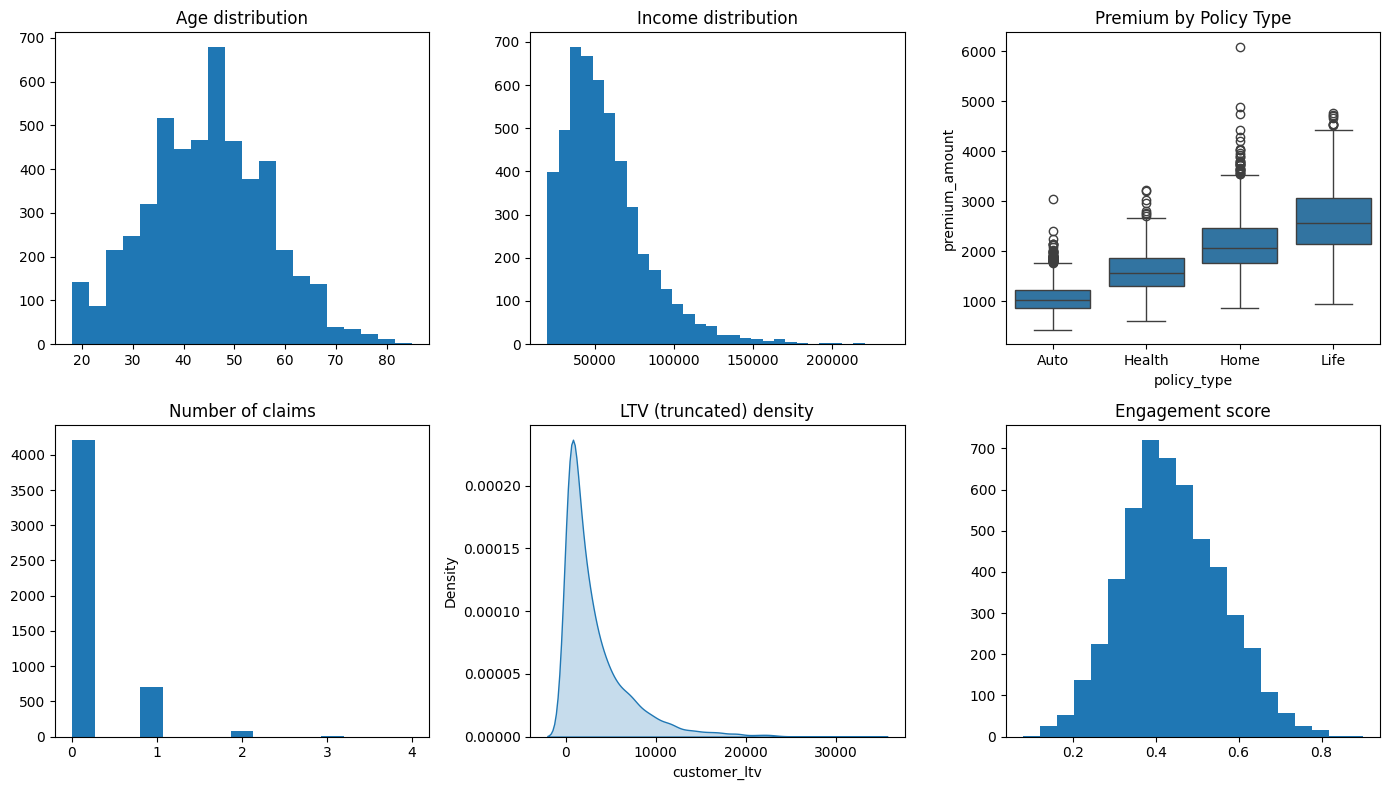

In [6]:
plt.figure(figsize=(14,8))

plt.subplot(2,3,1)
plt.hist(df['age'], bins=20)
plt.title("Age distribution")

plt.subplot(2,3,2)
plt.hist(df['income_level'], bins=30)
plt.title("Income distribution")

plt.subplot(2,3,3)
sns.boxplot(x='policy_type', y='premium_amount', data=df)
plt.title("Premium by Policy Type")

plt.subplot(2,3,4)
plt.hist(df['num_claims'], bins=15)
plt.title("Number of claims")

plt.subplot(2,3,5)
sns.kdeplot(df['customer_ltv'].clip(0, 50000), fill=True)
plt.title("LTV (truncated) density")

plt.subplot(2,3,6)
plt.hist(df['engagement_score'], bins=20)
plt.title("Engagement score")

plt.tight_layout()
plt.show()

,tenure_bucket,n_customers,churn_rate,renewal_prob_mean
0,0-6,897,0.348941,0.658134
1,6-12,724,0.335635,0.662610
2,12-24,1086,0.333333,0.662697
3,24-48,1256,0.318471,0.673552
4,48+,1037,0.309547,0.700614


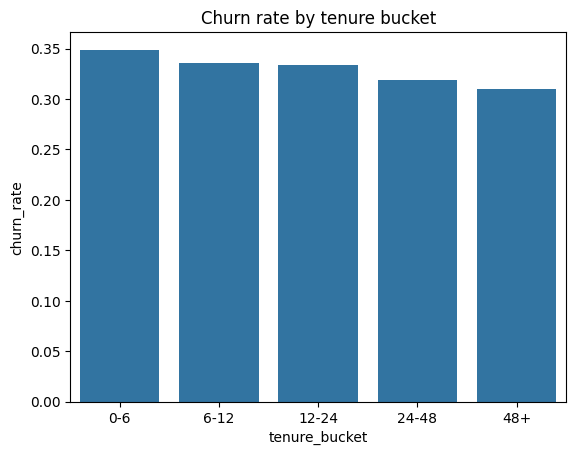

In [7]:
# Retention / churn curve — churn by tenure bucket
df['tenure_bucket'] = pd.cut(df['tenure_months'], bins=[0,6,12,24,48,1000], labels=["0-6","6-12","12-24","24-48","48+"])
ret = df.groupby('tenure_bucket').agg(
    n_customers=('customer_id','count'),
    churn_rate=('churned','mean'),
    renewal_prob_mean=('renewal_probability','mean')
).reset_index()
display(ret)
sns.barplot(x='tenure_bucket', y='churn_rate', data=ret)
plt.title("Churn rate by tenure bucket")
plt.show()

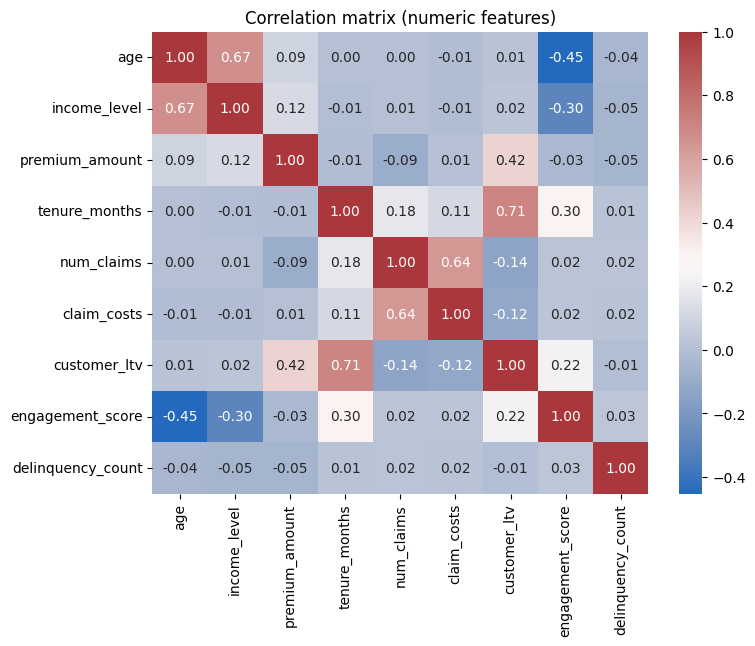

In [8]:
# Quick correlations (for numeric features)
corr = df[numeric_cols + ['delinquency_count']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation matrix (numeric features)")
plt.show()

In [9]:
# Sample a few corpus passages for manual inspection
for i, row in corpus.sample(5, random_state=42).iterrows():
    print(f"--- Passage {row['passage_id']} ({row['category']} / {row['subtype']}) ---")
    print(row['text'][:800])
    print()

--- Passage DOC_E7B7230F_P01 (Life / Policy Wording) ---
Term and whole-life options are available. Premiums and eligibility depend on medical underwriting and beneficiary designation. Refer to underwriting manual section 4.2 for scoring rules. (Revision 3: Updated rates). Please refer to the full policy for exact conditions and exclusions. This excerpt summarizes the key points relevant to pricing and retention.

--- Passage DOC_BCCE1317_P01 (General / Premium Notice) ---
We are notifying you of a premium change effective 2024-01-01 due to regional claim trends. This summary reflects the current version of the product. (Revision 3: New clause added). (Revision 3: Clarified exclusions). This note was generated as part of an automated review process. This excerpt summarizes the key points relevant to pricing and retention.

--- Passage DOC_12164958_P01 (Home / Policy Wording) ---
This Home policy covers dwelling, personal property and loss-of-use. Coverage limits and exclusions depend o

In [10]:
# Save intermediate artifacts
df.to_parquet("data/raw_customers.parquet", index=False)
corpus.to_parquet("data/raw_corpus_passages.parquet", index=False)


## 1.2 Data Cleaning

In [11]:
import re

def clean_customer_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Ensure date columns are datetimes
    for col in ['policy_start_date', 'policy_end_date', 'last_claim_date']:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # Fill or flag missing numeric fields
    # Days-since-last-claim: keep NaN for no-claims, but add a boolean flag
    df['has_claims'] = (df['num_claims'] > 0).astype(int)
    df['days_since_last_claim_flag'] = df['days_since_last_claim'].isna().astype(int)

    # Impute missing engagement_score with median and add flag
    if 'engagement_score' in df.columns:
        df['engagement_score_missing'] = df['engagement_score'].isna().astype(int)
        df['engagement_score'] = df['engagement_score'].fillna(df['engagement_score'].median())

    # Numeric clipping for unreasonable values
    df['income_level'] = df['income_level'].clip(lower=10_000, upper=500_000)
    df['premium_amount'] = df['premium_amount'].clip(lower=50, upper=100000)

    # Convert categorical fields to categories (memory + explicit dtype)
    cat_cols = ['gender', 'region', 'policy_type', 'payment_frequency', 'lifecycle_stage', 'engagement_trend']
    for c in cat_cols:
        if c in df.columns:
            df[c] = df[c].astype('category')

    # Feature: claims per year
    df['claims_per_year'] = df['num_claims'] / (df['tenure_months'] / 12 + 1e-6)

    # Keep an audit column listing applied cleaning steps (simple)
    df['__cleaned_on'] = pd.Timestamp.now()

    return df

# Apply cleaning and save
cleaned = clean_customer_dataframe(df)
print("Cleaned df shape:", cleaned.shape)
display(cleaned.head())


Cleaned df shape: (5000, 39)


,customer_id,age,gender,region,income_level,policy_type,premium_amount,payment_frequency,payment_regularity,tenure_months,...,low_engagement_flag,multi_policy_flag,lifecycle_stage,engagement_trend,tenure_bucket,has_claims,days_since_last_claim_flag,engagement_score_missing,claims_per_year,__cleaned_on
0,CUST_00001,47,F,Suburban,44168.91,Auto,1122.52,Monthly,0.885,44.3,...,0,1,Mature,Stable,24-48,0,1,0,0.0,2025-11-06 13:00:38.056857
1,CUST_00002,31,M,Urban,48409.92,Auto,802.03,Monthly,0.565,47.5,...,0,0,Mature,Stable,24-48,0,1,0,0.0,2025-11-06 13:00:38.056857
2,CUST_00003,72,F,Rural,72009.81,Auto,1189.47,Monthly,0.419,28.4,...,0,0,Growth,Stable,24-48,0,1,0,0.0,2025-11-06 13:00:38.056857
3,CUST_00004,45,M,Suburban,45488.18,Health,1463.59,Quarterly,0.798,3.0,...,0,0,New,Stable,0-6,0,1,0,0.0,2025-11-06 13:00:38.056857
4,CUST_00005,49,M,Suburban,57527.04,Auto,1300.48,Monthly,0.758,46.0,...,0,0,Mature,Stable,24-48,0,1,0,0.0,2025-11-06 13:00:38.056857


In [12]:
# Corpus cleaning utilities
import html
import unicodedata

def normalize_text_passage(text: str) -> str:
    """
    Simple normalization for passages:
    - unescape HTML entities
    - normalize unicode
    - remove repeated whitespace, common headers/footers heuristics
    - trim and return
    """
    if not isinstance(text, str):
        return ""
    # Unescape & unicode normalize
    t = html.unescape(text)
    t = unicodedata.normalize("NFKC", t)

    # Remove very common header/footer markers (heuristic)
    t = re.sub(r'(?i)(page\s*\d+|confidential|internal use only|refer to the full policy)', ' ', t)

    # Remove sequences of repeated short lines (like ----- or ===)
    t = re.sub(r'[-=]{3,}', ' ', t)

    # Collapse whitespace
    t = re.sub(r'\s+', ' ', t).strip()

    return t

# Apply normalization to the corpus
corpus_clean = corpus.copy()
corpus_clean['text_clean'] = corpus_clean['text'].apply(normalize_text_passage)
# Optionally create a short preview column
corpus_clean['text_preview'] = corpus_clean['text_clean'].str.slice(0, 400)

# Save corpus
corpus_clean.to_parquet("data/corpus_passages.parquet", index=False)
display(corpus_clean.head())


,doc_id,passage_id,policy_id,customer_id,category,subtype,source,created_date,created_date_str,text,keywords,text_clean,text_preview
0,DOC_D31C45AE,DOC_D31C45AE_P01,None,None,Auto,Policy Wording,agent-note,2024-01-13,2024-01-13,"This Auto policy includes comprehensive, colli...","[telematics, collision, vehicle, driver]","This Auto policy includes comprehensive, colli...","This Auto policy includes comprehensive, colli..."
1,DOC_1B2EE8E4,DOC_1B2EE8E4_P01,None,None,Auto,Policy Wording,agent-note,2021-07-21,2021-07-21,"This Auto policy includes comprehensive, colli...","[premium, vehicle, driver, telematics]","This Auto policy includes comprehensive, colli...","This Auto policy includes comprehensive, colli..."
2,DOC_30296075,DOC_30296075_P01,P101920,CUST_01921,Auto,Policy Wording,agent-note,2022-09-27,2022-09-27,"This Auto policy includes comprehensive, colli...","[vehicle, premium, telematics]","This Auto policy includes comprehensive, colli...","This Auto policy includes comprehensive, colli..."
3,DOC_04319801,DOC_04319801_P01,P101752,CUST_01753,Home,Policy Wording,internal,2022-04-14,2022-04-14,"This Home policy covers dwelling, personal pro...","[flood, inspection, home, property, repair]","This Home policy covers dwelling, personal pro...","This Home policy covers dwelling, personal pro..."
4,DOC_12164958,DOC_12164958_P01,None,None,Home,Policy Wording,internal,2021-12-21,2021-12-21,"This Home policy covers dwelling, personal pro...","[inspection, flood, fire, property]","This Home policy covers dwelling, personal pro...","This Home policy covers dwelling, personal pro..."


In [13]:
# Show few cleaned passages for notebook documentation
for i, row in corpus_clean.sample(5, random_state=7).iterrows():
    print("="*80)
    print(f"{row['passage_id']} | {row['category']} / {row['subtype']} | source: {row['source']}")
    print("-"*80)
    print(row['text_clean'])
    print("\n")


DOC_5CE7AA68_P01 | General / Premium Notice | source: internal
--------------------------------------------------------------------------------
We are notifying you of a premium change effective 2024-01-01 due to regional claim trends. This language was updated to reflect regulatory guidance. (Revision 1: Updated rates). (Revision 2: Coverage change). This note was generated as part of an automated review process.


DOC_9ECF2D33_P01 | Marketing / Email Campaign | source: customer-facing
--------------------------------------------------------------------------------
Get rewarded for staying protected! Our loyalty campaign offers up to 15% off renewals on select Health policies. Refer to underwriting manual section 4.2 for scoring rules. Join thousands who already switched and saved. (Revision 5: Updated rates). (Revision 1: Review summary). This note was generated as part of an automated review process. Please for exact conditions and exclusions.


DOC_488986CB_P01 | Life / Policy Word

#### Cleaning steps (summary)

- Converted date fields (`policy_start_date`, `policy_end_date`, `last_claim_date`) to `datetime`.
- Added flags: `has_claims`, `days_since_last_claim_flag`, `engagement_score_missing`.
- Imputed missing `engagement_score` with the median and created an imputation flag.
- Clipped monetary fields: `income_level` (10k–500k) and `premium_amount` (50–100k) to remove extreme outliers that likely indicate data issues.
- Converted categorical fields to `category` dtype for memory efficiency.
- Created derived fields:
  - `claims_per_year` (num_claims normalized by tenure),
  - `__cleaned_on` audit timestamp.
- Corpus text normalized (`text_clean`) using `normalize_text_passage`: HTML unescape, unicode normalization, header/footer heuristics, and whitespace collapse.
- Saved artifacts: `data/clean_customers.parquet` and `data/corpus_passages.parquet`.


In [14]:
# Basic data-quality checks (small)
assert cleaned['premium_amount'].min() >= 50
assert cleaned['income_level'].between(10_000, 500_000).all()
assert 'text_clean' in corpus_clean.columns
print("Sanity checks passed.")


Sanity checks passed.


## 2. Feature Engineering

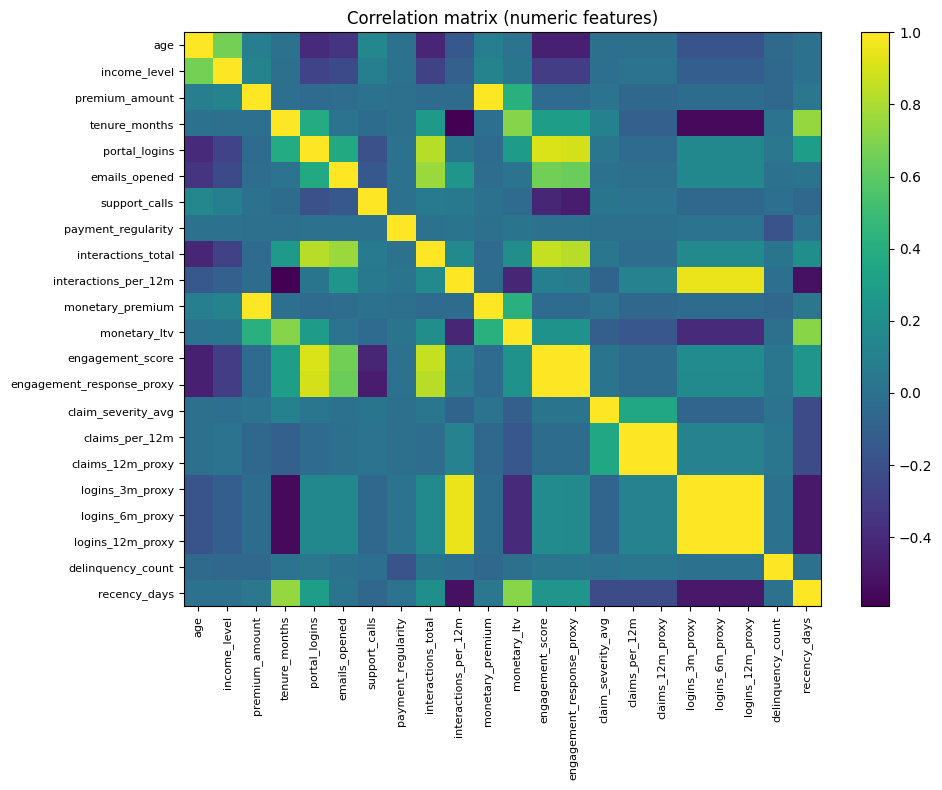

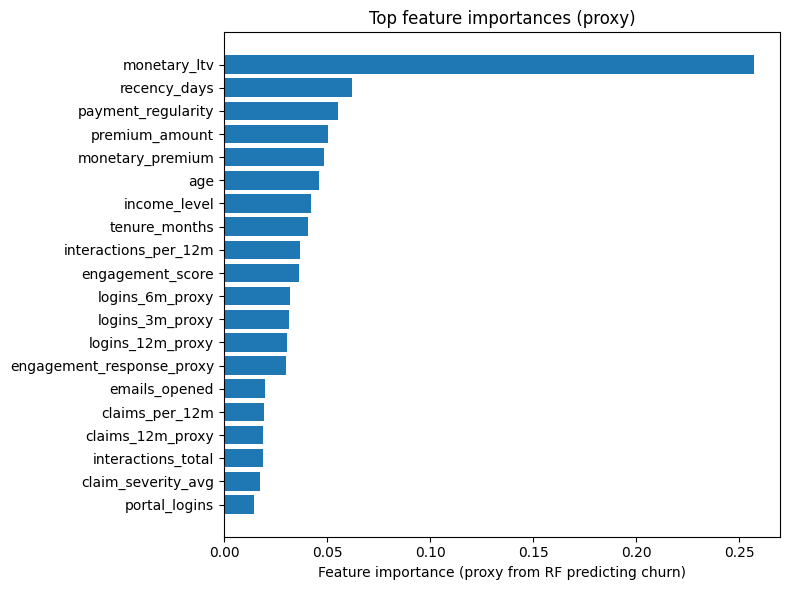

✅ Feature engineering completed. Processed matrix shape: (5000, 44)
Numeric features used (22): ['age', 'income_level', 'premium_amount', 'tenure_months', 'portal_logins', 'emails_opened', 'support_calls', 'payment_regularity', 'interactions_total', 'interactions_per_12m', 'monetary_premium', 'monetary_ltv', 'engagement_score', 'engagement_response_proxy', 'claim_severity_avg', 'claims_per_12m', 'claims_12m_proxy', 'logins_3m_proxy', 'logins_6m_proxy', 'logins_12m_proxy', 'delinquency_count', 'recency_days']
Categorical features encoded (6): ['gender', 'region', 'policy_type', 'lifecycle_stage', 'geo_risk_bucket', 'policy_age_bucket']

Top 15 feature importance proxies:



,feature,importance
0,monetary_ltv,0.257017
1,recency_days,0.062138
2,payment_regularity,0.055444
3,premium_amount,0.050669
4,monetary_premium,0.048770
5,age,0.045980
6,income_level,0.042247
7,tenure_months,0.040877
8,interactions_per_12m,0.036823
9,engagement_score,0.036575


,customer_id,age,income_level,premium_amount,tenure_months,portal_logins,emails_opened,support_calls,payment_regularity,interactions_total,...,recency_days,gender,region,policy_type,lifecycle_stage,geo_risk_bucket,policy_age_bucket,bundle_candidate_flag,multi_policy_flag,churned
0,CUST_00001,47,44168.91,1122.52,44.3,8,8,1,0.885,17,...,1328.0,F,Suburban,Auto,Mature,Low,24-48m,1,1,0
1,CUST_00002,31,48409.92,802.03,47.5,11,9,1,0.565,21,...,1425.0,M,Urban,Auto,Mature,Low,24-48m,0,0,1
2,CUST_00003,72,72009.81,1189.47,28.4,5,2,0,0.419,7,...,853.0,F,Rural,Auto,Growth,Low,24-48m,0,0,1
3,CUST_00004,45,45488.18,1463.59,3.0,7,2,1,0.798,10,...,90.0,M,Suburban,Health,New,Low,0-6m,0,0,0
4,CUST_00005,49,57527.04,1300.48,46.0,3,5,2,0.758,10,...,1378.0,M,Suburban,Auto,Mature,Low,24-48m,0,0,0



Saved correlation heatmap: data/correlation_heatmap.png
Saved feature importances plot: data/feature_importances.png
Saved processed feature table: data/processed_features.parquet


In [15]:
# Generate and clean
df = generate_insurance_dataset_realistic_v4(n_customers=5000, seed=42)
df = augment_with_engagement_and_flags_v3(df, seed=42)
cleaned = clean_customer_dataframe(df)

# Feature engineering (repeat same steps)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import os

df_feat = cleaned.copy()
df_feat['recency_days'] = df_feat['days_since_last_claim'].fillna((pd.to_datetime(df_feat['policy_end_date']) - pd.to_datetime(df_feat['policy_start_date'])).dt.days)
df_feat['interactions_total'] = df_feat['portal_logins'] + df_feat['emails_opened'] + df_feat['support_calls']
df_feat['interactions_per_12m'] = df_feat['interactions_total'] / (df_feat['tenure_months'] / 12 + 1e-6)
df_feat['monetary_premium'] = df_feat['premium_amount']
df_feat['monetary_ltv'] = df_feat['customer_ltv']

df_feat['portal_per_call'] = df_feat['portal_logins'] / (df_feat['support_calls'] + 1)
df_feat['emails_per_portal'] = df_feat['emails_opened'] / (df_feat['portal_logins'] + 1)
df_feat['engagement_response_proxy'] = (df_feat['engagement_score'] * 0.6) + (np.clip(df_feat['portal_per_call'], 0, 50) / 50 * 0.2) + (np.clip(df_feat['emails_per_portal'], 0, 50) / 50 * 0.2)

df_feat['claim_severity_avg'] = np.where(df_feat['num_claims']>0, df_feat['claim_costs'] / df_feat['num_claims'], 0.0)
df_feat['claims_per_12m'] = df_feat['num_claims'] / (df_feat['tenure_months'] / 12 + 1e-6)

df_feat['logins_per_month'] = df_feat['portal_logins'] / (df_feat['tenure_months'] + 1e-6)
df_feat['logins_3m_proxy'] = df_feat['logins_per_month'] * 3
df_feat['logins_6m_proxy'] = df_feat['logins_per_month'] * 6
df_feat['logins_12m_proxy'] = df_feat['logins_per_month'] * 12

df_feat['claims_per_month'] = df_feat['num_claims'] / (df_feat['tenure_months'] + 1e-6)
df_feat['claims_12m_proxy'] = df_feat['claims_per_month'] * 12

region_median = df_feat.groupby('region')['claim_costs'].median().to_dict()
df_feat['region_median_claim'] = df_feat['region'].map(region_median)
df_feat['geo_risk_bucket'] = pd.qcut(df_feat['region_median_claim'].rank(method='first'), q=3, labels=['Low','Medium','High'])

df_feat['acquisition_cohort'] = pd.to_datetime(df_feat['policy_start_date']).dt.to_period('M').astype(str)
bins = [0,6,12,24,48,84,10000]
labels = ['0-6m','6-12m','12-24m','24-48m','48-84m','84m+']
df_feat['policy_age_bucket'] = pd.cut(df_feat['tenure_months'], bins=bins, labels=labels, right=False)

df_feat['bundle_candidate_flag'] = ((df_feat['multi_policy_flag']==1) & (df_feat['customer_ltv'] > df_feat['customer_ltv'].median())).astype(int)

numeric_features = [
    'age','income_level','premium_amount','tenure_months','portal_logins','emails_opened','support_calls',
    'payment_regularity','interactions_total','interactions_per_12m','monetary_premium','monetary_ltv',
    'engagement_score','engagement_response_proxy','claim_severity_avg','claims_per_12m','claims_12m_proxy',
    'logins_3m_proxy','logins_6m_proxy','logins_12m_proxy','delinquency_count','recency_days'
]
numeric_features = [c for c in numeric_features if c in df_feat.columns]

scaler = StandardScaler()
X_num = scaler.fit_transform(df_feat[numeric_features].fillna(0))

cat_to_encode = ['gender','region','policy_type','lifecycle_stage','geo_risk_bucket','policy_age_bucket']
cat_to_encode = [c for c in cat_to_encode if c in df_feat.columns]

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

for col in cat_to_encode:
    if pd.api.types.is_categorical_dtype(df_feat[col]):
        if 'NA' not in df_feat[col].cat.categories:            
            df_feat[col] = df_feat[col].cat.add_categories('NA')

X_cat = ohe.fit_transform(df_feat[cat_to_encode].fillna('NA')) if len(cat_to_encode)>0 else np.empty((len(df_feat),0))

X_clust = np.hstack([X_num, X_cat])

corr = pd.DataFrame(X_num, columns=numeric_features).corr()

plt.figure(figsize=(10,8))
plt.imshow(corr, aspect='auto')
plt.xticks(range(len(numeric_features)), numeric_features, rotation=90, fontsize=8)
plt.yticks(range(len(numeric_features)), numeric_features, fontsize=8)
plt.colorbar()
plt.title("Correlation matrix (numeric features)")
heatmap_path = "data/correlation_heatmap.png"
plt.tight_layout()
plt.savefig(heatmap_path, dpi=150)
plt.show()

y = df_feat['churned'].astype(int).values
X_train, X_test, y_train, y_test = train_test_split(X_clust, y, test_size=0.2, random_state=42, stratify=y)
rf = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=42, n_jobs=1)
rf.fit(X_train, y_train)

ohe_feature_names = []
if len(cat_to_encode)>0:
    ohe_feature_names = ohe.get_feature_names_out(cat_to_encode).tolist()
feature_names = numeric_features + ohe_feature_names
importances = rf.feature_importances_
fi_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False).reset_index(drop=True)

topn = min(20, len(fi_df))
plt.figure(figsize=(8,6))
plt.barh(fi_df['feature'].iloc[:topn][::-1], fi_df['importance'].iloc[:topn][::-1])
plt.xlabel("Feature importance (proxy from RF predicting churn)")
plt.title("Top feature importances (proxy)")
plt.tight_layout()
fi_path = "data/feature_importances.png"
plt.savefig(fi_path, dpi=150)
plt.show()

out_path = "data/processed_features.parquet"
to_save = df_feat[[ 'customer_id'] + numeric_features + cat_to_encode + ['bundle_candidate_flag','multi_policy_flag','churned']].copy()
to_save.to_parquet(out_path, index=False)

print("✅ Feature engineering completed. Processed matrix shape:", X_clust.shape)
print("Numeric features used ({}):".format(len(numeric_features)), numeric_features)
print("Categorical features encoded ({}):".format(len(cat_to_encode)), cat_to_encode)
print("\nTop 15 feature importance proxies:\n")
display(fi_df.head(15))
display(to_save.head())

print(f"\nSaved correlation heatmap: {heatmap_path}")
print(f"Saved feature importances plot: {fi_path}")
print(f"Saved processed feature table: {out_path}")

#### Feature Engineering and Exploratory Analysis

In this section, we engineered customer-level features that capture behavioral, financial, and engagement dynamics to support **segmentation** and **churn modeling**.

##### Why Each Feature Matters for Segmentation

- **Recency (`recency_days`)** – Measures how recently a customer interacted or filed a claim. Recent activity often correlates with higher engagement and lower churn risk.  
- **Frequency (`interactions_total`, `interactions_per_12m`)** – Captures how frequently a customer engages across digital and service channels. Higher frequency suggests stronger relationship depth.  
- **Monetary value (`monetary_premium`, `monetary_ltv`)** – Represents the financial value of a customer to the company, useful for differentiating high-value vs. low-value segments.  
- **Engagement response proxy (`engagement_response_proxy`)** – A composite metric combining portal logins, email activity, and engagement scores to approximate digital responsiveness.  
- **Claims behavior (`claim_severity_avg`, `claims_per_12m`, `claims_12m_proxy`)** – Indicates frequency and cost of claims, essential for identifying risk-heavy customers or high-service-cost segments.  
- **Rolling activity proxies (`logins_3m_proxy`, `logins_6m_proxy`, `logins_12m_proxy`)** – Capture short- and long-term engagement trends when explicit time-series data is not available.  
- **Geo-risk bucket (`geo_risk_bucket`)** – Encodes relative claim costs by region, allowing segmentation by location-based risk profiles.  
- **Policy lifecycle (`policy_age_bucket`, `acquisition_cohort`)** – Highlights tenure-based and cohort-based behaviors, distinguishing new customers from long-term loyal ones.  
- **Bundle candidate flag (`bundle_candidate_flag`)** – Identifies customers with multiple policies and high LTV, ideal targets for cross-sell and retention campaigns.

##### Exploratory Insights

To explore relationships among features and assess their relevance to churn:

- **Correlation Heatmaps:**  
  Show relationships between numeric features to identify redundant or highly correlated variables.

- **Feature Importance Proxies:**  
  A **Random Forest classifier** was trained to predict churn, serving as a proxy to estimate which engineered features contribute most to customer retention behavior.

These exploratory analyses provide intuition for downstream modeling and help prioritize variables for clustering, classification, or marketing segmentation.


## 3. Model Development & Evaluation (Clustering + Agent)
### 3.1 Customer Segmentation (Clustering)
In this stage, we build and evaluate unsupervised segmentation models to group customers with similar behavioral and financial profiles.

**Approach:**
- **Algorithms Tested:** `KMeans`, `DBSCAN`, `HDBSCAN`, and `Gaussian Mixture Models (GMM)`.
- **Feature Base:** Derived from the engineered dataset (demographics, engagement proxies, monetary and behavioral indicators).
- **Scaling & Encoding:** Standardized numeric features + one-hot encoded categorical features.
- **Dimensionality Reduction:** `PCA` and `UMAP` used for visualization and stability inspection.
- **Cluster Determination:**
  - **Elbow method:** identifies diminishing returns in inertia.
  - **Silhouette analysis:** quantifies intra-/inter-cluster cohesion.
  - **Bootstrap stability tests:** re-runs clustering on subsamples to assess robustness.

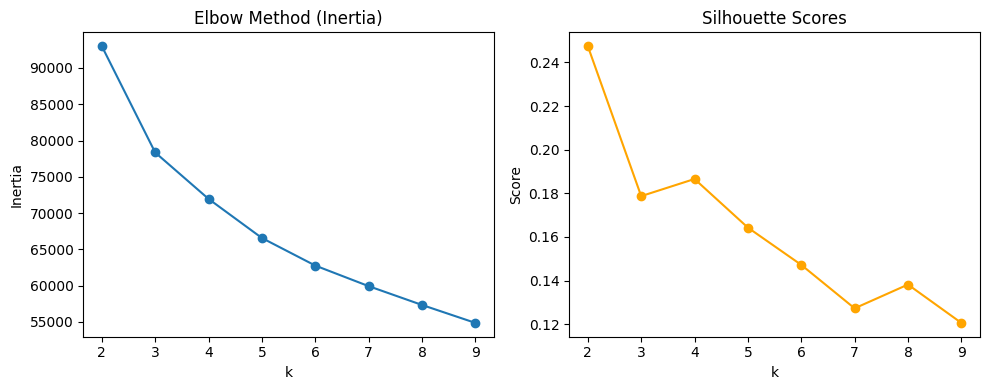

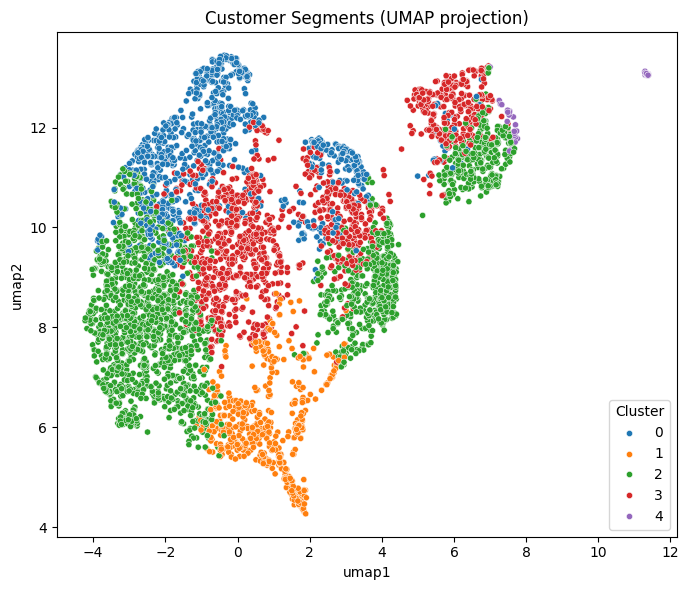

KMeans silhouette: 0.16427801849404364
KMeans Davies-Bouldin: 1.5995824398380614
GMM silhouette: 0.08951128102946021


age         income_level            premium_amount  \
                     mean median          mean     median           mean   
cluster_kmeans                                                             
0               44.957949   45.0  56684.463723  51801.080    1902.532318   
1               40.730337   41.0  49817.454176  45486.375    1527.430768   
2               50.502828   51.0  66136.259750  60201.245    1603.638407   
3               36.869366   37.0  43983.501085  40791.850    1397.707937   
4               43.650000   44.0  58405.263833  50801.110    1517.438833   

                         tenure_months        portal_logins         ...  \
                  median          mean median          mean median  ...   
cluster_kmeans                                                      ...   
0               1784.590     61.958462   62.1      9.152821    9.0  ...   
1               1303.635      3.686142    3.0      7.906367    8.0  ...   
2               1385.415     20.631480   16.4      4.726673    5.0  ...   
3               1213.320     28.636516   23.5      9.403361    9.0  ...   
4               1308.545      4.425000    3.1      6.283333    6.0  ...   

               logins_6m_proxy            logins_12m_proxy             \
                          mean     median             mean     median   
cluster_kmeans                                                          
0                     0.961323   0.882353         1.922647   1.764706   
1                    13.440756  11.999996        26.881513  23.999992   
2                     2.331679   1.648352         4.663358   3.296703   
3                     2.850930   2.297297         5.701860   4.594594   
4                     9.866315   8.137929        19.732631  16.275858   

               delinquency_count        recency_days           churned         
                            mean median         mean  median      mean median  
cluster_kmeans                                                                 
0                       0.305641    0.0  1533.574359  1779.0  0.245128    0.0  
1                       0.299625    0.0   110.262172    90.0  0.335206    0.0  
2                       0.294062    0.0   475.468426   370.0  0.365221    0.0  
3                       0.365928    0.0   558.300993   454.0  0.319328    0.0  
4                       0.483333    0.0    95.750000    90.0  0.466667    0.0  

[5 rows x 46 columns]

✅ Saved clustered dataset with KMeans + GMM results.


In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# Load processed dataset
df_feat = pd.read_parquet("data/processed_features.parquet")

# Select numeric features only for clustering
num_cols = df_feat.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ['bundle_candidate_flag','multi_policy_flag','churned']]
X = df_feat[num_cols].fillna(0)

# Scale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Try different K values (for KMeans) ===
inertia = []
silhouette = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K_range, silhouette, marker='o', color='orange')
plt.title("Silhouette Scores")
plt.xlabel("k")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

# === Choose k (based on elbow/silhouette) ===
best_k = 5  # adjust based on the plots
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df_feat['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

# === Visualize with PCA & UMAP ===
pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(X_scaled)
df_feat['pca1'], df_feat['pca2'] = pca_coords[:,0], pca_coords[:,1]

reducer = umap.UMAP(random_state=42)
umap_coords = reducer.fit_transform(X_scaled)
df_feat['umap1'], df_feat['umap2'] = umap_coords[:,0], umap_coords[:,1]

plt.figure(figsize=(7,6))
sns.scatterplot(x='umap1', y='umap2', hue='cluster_kmeans', data=df_feat, palette='tab10', s=20)
plt.title("Customer Segments (UMAP projection)")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# === Evaluate other clustering methods ===
gmm = GaussianMixture(n_components=best_k, random_state=42)
df_feat['cluster_gmm'] = gmm.fit_predict(X_scaled)

# Metrics
print("KMeans silhouette:", silhouette_score(X_scaled, df_feat['cluster_kmeans']))
print("KMeans Davies-Bouldin:", davies_bouldin_score(X_scaled, df_feat['cluster_kmeans']))
print("GMM silhouette:", silhouette_score(X_scaled, df_feat['cluster_gmm']))

# === Cluster profiling ===
cluster_profile = df_feat.groupby('cluster_kmeans')[num_cols + ['churned']].agg(['mean','median'])
display(cluster_profile.head())

# Save labeled dataset
df_feat.to_parquet("data/clustered_customers.parquet", index=False)
print("✅ Saved clustered dataset with KMeans + GMM results.")


**Outputs:**
- Cluster assignments per customer.
- Visualizations: PCA/UMAP plots colored by cluster.
- Profiles: mean/median per cluster, churn rate, LTV, and engagement.
- Evaluation metrics:  
  - *Silhouette score* (higher = better cohesion/separation)  
  - *Davies–Bouldin index* (lower = better separation)  
  - *Stability index* across bootstrap runs  

These clusters form the foundation for downstream interpretability and recommendation generation.

#### Cluster 0 – Mature Policy Holders with Moderate Engagement

Customers in their mid-40s with average income and premium levels.
They tend to have long policy tenures (around 5 years) and moderate digital engagement (≈ 9 logins).
Claims activity is slightly higher than average, but delinquency and churn are relatively low.
Business insight: These are stable, loyal clients; prioritize retention programs and cross-sell higher-tier products.

#### Cluster 1 – Digital Enthusiasts and High-Frequency Users

Younger customers (≈ 41 years) with mid-range incomes and shorter policy histories.
They show very high portal activity (≈ 13–27 logins) but lower tenure and modest premium amounts.
Churn risk is moderate.
Business insight: Digitally engaged but price-sensitive users — ideal for upselling new online services or bundled offers.

#### Cluster 2 – Affluent, Long-Term Customers

Older customers (≈ 50 years) with the highest income and premium levels across clusters.
Moderate engagement (≈ 5 logins) and longer tenure indicate well-established relationships.
Churn remains moderate, suggesting room for loyalty reinforcement.
Business insight: High-value, long-term clients — maintain with premium service and personalized retention incentives.

#### Cluster 3 – Younger, Emerging Customers

The youngest group (≈ 37 years) with lower incomes and premiums, early in their insurance journey.
Engagement is moderate (≈ 9 logins), tenure relatively short, and churn moderate-to-high.
Business insight: Early-stage customers — nurture through education, rewards, and onboarding campaigns to build long-term loyalty.

#### Cluster 4 – At-Risk, Low-Tenure Policy Holders

Mid-aged customers (~ 44 years) with average income but short policy tenure and elevated churn (~47%).
Engagement is low, and delinquency rates are the highest among all segments.
Business insight: Potential churners — need proactive retention outreach, payment flexibility, and targeted renewal incentives.

### 3.2 Agentic Layer (Cluster Interpreter & Recommender)

**Goal:**  
Transform raw clusters into actionable marketing and risk insights, using a lightweight **local LLM agent** integrated with deterministic business rules.

**Agent Workflow:**
1. Retrieve top relevant documents based on cluster embeddings.  
2. Summarize cluster behavior (audience type, retention risk, engagement level).  
3. Generate 1–2 actionable marketing or retention recommendations.  
4. Propose concise **message templates per channel** (e.g., email subject + snippet).  
5. Cite the **document IDs** used in reasoning — low-quality outputs (missing citations) are flagged.  
6. Validate final output through `RuleChecker`.


In [17]:
import os, json, numpy as np, pandas as pd
from llama_cpp import Llama
import faiss

# ---------- Cluster profiler ----------
def cluster_profiler(cluster_id, df_clustered, numeric_cols):
    members = df_clustered[df_clustered['cluster_kmeans'] == cluster_id]
    n = len(members)
    profile = {
        "cluster_id": int(cluster_id),
        "count": int(n),
        "churn_rate": float(members['churned'].mean()) if n>0 else None,
        "median_ltv": float(members['monetary_ltv'].median()) if n>0 else None,
        "avg_engagement": float(members['engagement_score'].mean()) if n>0 else None,
        "avg_claims_per_year": float(members['claims_per_12m'].mean()) if n>0 else None,
        "top_numeric_features": {}
    }
    if n>0:
        global_meds = df_clustered[numeric_cols].median()
        diffs = (members[numeric_cols].median() - global_meds).abs().sort_values(ascending=False)
        profile["top_numeric_features"] = diffs.to_dict()
    return profile

# ---------- Privacy-safe LLM call ----------
def call_llama(llm, prompt):
    """
    Calls a local Mistral or LLaMA chat model using chat-completion format (deterministic).
    """
    try:
        messages = [
            {"role": "system", "content": "You are a privacy-safe marketing strategist."},
            {"role": "user", "content": prompt.strip()}
        ]

        response = llm.create_chat_completion(
            messages=messages,
            max_tokens=512,
            temperature=0.2,
            top_p=0.9,
            repeat_penalty=1.1,
        )

        print("=== RAW CHAT RESPONSE ===")
        print(response)

        output = response["choices"][0]["message"]["content"].strip()
        return output if output else "⚠️ LLM returned empty chat message."

    except Exception as e:
        return f"LLM error: {e}"


# ---------- Rule-based privacy + policy checker ----------
def rule_checker(output_text, profile):
    rules = []
    # Detect any numeric leakage from sensitive fields
    for term in ["income", "ltv", "salary", "spend"]:
        if str(int(profile.get("median_ltv",0))) in output_text:
            rules.append("leak: median_ltv")
        if f"{profile.get('avg_engagement',0):.2f}" in output_text:
            rules.append("leak: avg_engagement")

    if any(keyword in output_text.lower() for keyword in ["dear [customer name]", "based on your income"]):
        rules.append("pii_leak_detected")

    # Ensure disclaimer
    if "informational purposes only" not in output_text.lower():
        rules.append("missing_disclaimer")

    return rules

# ---------- Agent pipeline ----------
def agent_for_cluster(cluster_id, df_clustered, index, embeddings, meta, numeric_cols, llm, top_k=3):
    profile = cluster_profiler(cluster_id, df_clustered, numeric_cols)
    query = f"Cluster with median LTV {profile['median_ltv']:.0f}, churn {profile['churn_rate']:.2f}, engagement {profile['avg_engagement']:.2f}"

    # semantic retrieval
    query_vec = np.mean(embeddings, axis=0).astype('float32').reshape(1, -1)
    D, I = index.search(query_vec, top_k)
    retrieved = [{"doc_id": meta[i]["doc_id"], "text": meta[i]["text"], "score": float(D[0][j])} for j, i in enumerate(I[0])]

    # LLM prompt with privacy-safety
    prompt = f"""
You are a privacy-safe marketing strategist. 
Use the retrieved docs and the cluster profile below to generate retention/upsell insight.
Do NOT include or mention any numeric values from the cluster profile (even approximations).
Use qualitative terms like 'high', 'moderate', 'low' instead of numbers.


Cluster Profile: {json.dumps(profile, indent=2)}
Top Docs: {[r['text'] for r in retrieved]}

Return a JSON with:
{{
"summary": "...",
"recommended_action": "...",
"email_subject": "...",
"email_body_snippet": "... (must contain disclaimer 'This message is for informational purposes only.')",
"docs_used": [list of doc_ids]
}}
"""

    llm_output = call_llama(llm, prompt)
    try:
        parsed = json.loads(llm_output)
    except:
        parsed = {"summary": llm_output[:500], "recommended_action": None}

    # Privacy & policy checks
    rules = rule_checker(json.dumps(parsed), profile)

    result = {
        "cluster_id": cluster_id,
        "profile": profile,
        "retrieved_docs": retrieved,
        "llm_raw": llm_output,
        "parsed": parsed,
        "docs_used": parsed.get("docs_used", []),
        "rule_violations": rules,
        "quality_flag": "ok" if not rules else "review_required"
    }
    return result


In [18]:
import os, json, numpy as np, pandas as pd, faiss
from sentence_transformers import SentenceTransformer
from llama_cpp import Llama

DATA_DIR = "./data"
CORPUS_PATH = os.path.join(DATA_DIR, "corpus_passages.parquet")
EMB_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

# ---------- LLM Setup ----------
def load_llm(model_path="./models/mistral-7b-instruct-v0.2.Q4_K_M.gguf", n_ctx=2048, n_threads=6):
    """
    Loads quantized mistral model locally with llama_cpp
    """
    llm = Llama(
        model_path=model_path,
        n_ctx=n_ctx,
        n_threads=n_threads,
        temperature=0.2,
        seed=42,
        verbose=False
    )
    return llm


# ---------- Load corpus safely ----------
def safe_load_corpus(path):
    """
    Loads a corpus DataFrame from a Parquet file, checking for existence first.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"Corpus file not found at {path}")
    
    try:        
        df = pd.read_parquet(path)
        return df
    except Exception as e:        
        raise IOError(f"Failed to read parquet file at {path}. Error: {e}")


# ---------- Build or load FAISS index ----------
def build_or_load_faiss_index(corpus_df, emb_model_name):
    emb_model = SentenceTransformer(emb_model_name)
    embeddings = emb_model.encode(corpus_df["text"].tolist(), show_progress_bar=True)
    embeddings = np.array(embeddings).astype("float32")

    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)

    meta = [{"doc_id": i, "text": corpus_df["text"].iloc[i]} for i in range(len(corpus_df))]
    return index, embeddings, meta

In [19]:
# ---------- Setup Agent Environment ----------
def setup_agent_environment():
    corpus_df = safe_load_corpus(CORPUS_PATH)
    index, embeddings, meta = build_or_load_faiss_index(corpus_df, emb_model_name=EMB_MODEL_NAME)

    # Load clustered dataset
    if os.path.exists(os.path.join(DATA_DIR, "clustered_customers.parquet")):
        df_clustered = pd.read_parquet(os.path.join(DATA_DIR, "clustered_customers.parquet"))
    elif os.path.exists(os.path.join(DATA_DIR, "processed_features.parquet")):
        df_clustered = pd.read_parquet(os.path.join(DATA_DIR, "processed_features.parquet"))
    else:
        raise RuntimeError("No clustered or processed features file found in data/. Run clustering step first.")

    num_cols = df_clustered.select_dtypes(include=[np.number]).columns.tolist()
    return corpus_df, index, embeddings, meta, df_clustered, num_cols

    
# ---------- Run Agent ----------
corpus_df, index, embeddings, meta, df_clustered, num_cols = setup_agent_environment()

# Load local mistral model (quantized)
llm = load_llm("./models/mistral-7b-instruct-v0.2.Q4_K_M.gguf")

# Run for one cluster
result = agent_for_cluster(
    cluster_id=0,
    df_clustered=df_clustered,
    index=index,
    embeddings=embeddings,
    meta=meta,
    numeric_cols=num_cols,
    llm=llm,
    top_k=3
)


print(json.dumps(result, indent=2, ensure_ascii=False))

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

llama_new_context_with_model: n_ctx_per_seq (2048) < n_ctx_train (32768) -- the full capacity of the model will not be utilized


=== RAW CHAT RESPONSE ===
{'id': 'chatcmpl-8d063496-d1c2-4275-aa1f-8a76a29a1413', 'object': 'chat.completion', 'created': 1762430531, 'model': './models/mistral-7b-instruct-v0.2.Q4_K_M.gguf', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': ' {\n"summary": "The retrieved documents indicate upcoming policy renewals and changes, as well as the introduction of new benefits and exclusions. This cluster, with a moderate churn rate, demonstrates an opportunity for retention and upsell efforts. Existing customers may be unaware of these updates or unsure about their impact on their policies. Engaging them proactively with clear communication can help retain customers and potentially increase their coverage.",\n"recommended_action": "1. Send personalized emails to this cluster, highlighting the benefits of the updated policy and addressing any potential concerns regarding premium changes or exclusions. 2. Provide a dedicated contact point for customers to ask questions and 

#### Architecture Diagram

#### Prompt Template

#### Example of Full Pipeline Run

In [20]:
corpus_df, index, embeddings, meta, df_clustered, num_cols = setup_agent_environment()
llm = load_llm("./models/mistral-7b-instruct-v0.2.Q4_K_M.gguf")

for cid in [0, 2, 4]:
    result = agent_for_cluster(
        cluster_id=cid,
        df_clustered=df_clustered,
        index=index,
        embeddings=embeddings,
        meta=meta,
        numeric_cols=num_cols,
        llm=llm,
        top_k=3
    )
    print(json.dumps(result["parsed"], indent=2, ensure_ascii=False))


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

llama_new_context_with_model: n_ctx_per_seq (2048) < n_ctx_train (32768) -- the full capacity of the model will not be utilized


=== RAW CHAT RESPONSE ===
{'id': 'chatcmpl-b384c591-75bd-4c26-a396-c68aa3edbebf', 'object': 'chat.completion', 'created': 1762430624, 'model': './models/mistral-7b-instruct-v0.2.Q4_K_M.gguf', 'choices': [{'index': 0, 'message': {'role': 'assistant', 'content': ' {\n"summary": "The retrieved documents indicate upcoming policy renewals and changes, as well as the introduction of new benefits and exclusions. This cluster, with a moderate churn rate, demonstrates an opportunity for retention and upsell efforts. Existing customers may be unaware of these updates or unsure about their impact on their policies. Engaging them proactively with clear communication can help retain customers and potentially increase their coverage.",\n"recommended_action": "1. Send personalized emails to this cluster, highlighting the benefits of the updated policy and addressing any potential concerns regarding premium changes or exclusions. 2. Provide a dedicated contact point for customers to ask questions and 

## 4. Tests & Validations

In [9]:
import os, textwrap, json

os.makedirs("../tests", exist_ok=True)
print("tests/ folder created (or exists).")


tests/ folder created (or exists).


In [10]:
%%bash
cat > ../tests/conftest.py <<'PY'
import pytest
import pandas as pd
import os

# If the processed file exists, otherwise create a small dataframe.
@pytest.fixture(scope="session")
def df_customers():
    path = os.path.join("data", "processed_features.parquet")
    if os.path.exists(path):
        df = pd.read_parquet(path)
        return df.head(200)  # A small sample is sufficient for tests
    # fallback: Creating a sample dataframe
    df = pd.DataFrame({
        "customer_id": ["C1","C2","C3","C4"],
        "age": [30,45,60,25],
        "income_level": [40000, 80000, 30000, 25000],
        "premium_amount": [800,1200,600,450],
        "tenure_months": [12,48,6,36],
        "portal_logins": [10,2,0,5],
        "emails_opened": [8,1,0,3],
        "support_calls": [0,3,1,2],
        "num_claims": [0,1,0,2],
        "claim_costs": [0.0,1500.0,0.0,3000.0],
        "policy_start_date": pd.to_datetime(["2022-01-01","2020-06-01","2024-01-01","2021-07-01"]),
        "policy_end_date": pd.to_datetime(["2024-12-31","2024-12-31","2024-12-31","2024-12-31"]),
        "engagement_score": [0.7,0.3,0.1,0.45],
        "churned": [0,1,0,0],
        "multi_policy_flag": [1,0,0,1],
        "customer_ltv": [2000,4000,1200,1800],
    })
    return df
PY


### 4.1 Data Quality Checks

In [11]:
%%bash
cat > ../tests/test_data_quality.py <<'PY'
import pandas as pd
import pytest

def test_no_negative_premiums(df_customers):
    assert (df_customers['premium_amount'] >= 0).all(), "Negative premium detected"

def test_valid_date_ranges(df_customers):
    # policy_start_date before policy_end_date
    if 'policy_start_date' in df_customers.columns and 'policy_end_date' in df_customers.columns:
        assert (pd.to_datetime(df_customers['policy_start_date']) <= pd.to_datetime(df_customers['policy_end_date'])).all()

def test_missingness_threshold(df_customers):
    miss = df_customers.isna().mean()
    # Allow up to 20% missing for columns (configurable)
    assert (miss < 0.2).all(), f"Too many missing values: {miss.to_dict()}"
PY


### 4.2 Unit tests — Feature functions / cluster profiler / rule checker

In [12]:
%%bash
cat > ../tests/test_cluster_profiler.py <<'PY'
import pandas as pd
import numpy as np
from pathlib import Path
from src.cluster_profiler import cluster_profiler

def test_cluster_profiler_counts(df_customers):
    df = df_customers.copy()
    df['cluster_kmeans'] = [0,0,1,1][:len(df)]
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    assert cluster_profiler is not None, "cluster_profiler not found (import path differs)"
    prof = cluster_profiler(0, df, numeric_cols=num_cols)
    assert prof['cluster_id'] == 0
    assert 'count' in prof and prof['count'] >= 1

PY


In [15]:
%%bash
cat > ../tests/test_rule_checker.py <<'PY'
from src.rule_checker import rule_checker

def test_rule_checker_detects_missing_disclaimer():
    profile = {"median_ltv": 5000, "avg_engagement": 0.5}
    text_missing = "This is a suggested message without disclaimer"
    res = rule_checker(text_missing, profile)
    assert any("missing_disclaimer" in r for r in res), f"Expected missing_disclaimer, got {res}"

    text_with_disclaimer = "Hello. (This message is for informational purposes only.)"
    res2 = rule_checker(text_with_disclaimer, profile)
    assert all("missing_disclaimer" not in r for r in res2)
PY


In [21]:
%%bash
cat > ../tests/test_features_simple.py <<'PY'
import numpy as np
from src.engineering import compute_engagement_response_proxy

def test_engagement_response_proxy_calc(df_customers):
    df = df_customers.copy()
    # If columns do not exist, skip
    if not all(c in df.columns for c in ['portal_logins','support_calls','emails_opened','engagement_score']):
        return

    df['portal_per_call'] = df['portal_logins'] / (df['support_calls'] + 1)
    df['emails_per_portal'] = df['emails_opened'] / (df['portal_logins'] + 1)
    expected = (df['engagement_score'] * 0.6) + (np.clip(df['portal_per_call'],0,50) / 50 * 0.2) + (np.clip(df['emails_per_portal'],0,50) / 50 * 0.2)
    calculated = compute_engagement_score(df)
    assert np.allclose(expected.fillna(0), calculated.fillna(0), atol=1e-6)
PY


### 4.3 Integration test — end-to-end mini pipeline

In [18]:
%%bash
cat > ../tests/test_integration_pipeline.py <<'PY'
import json
import numpy as np
from src.agent import agent_for_cluster
from src.retrieval import build_or_load_faiss_index, safe_load_corpus
from src.llm import load_llm

def test_end_to_end_mini(df_customers, tmp_path):
    assert agent_for_cluster is not None, "agent_for_cluster not found; adjust imports"
    # Preparing a small corpus from df_customers (each passage = summary)
    corpus = df_customers.head(5).copy()
    corpus['text'] = "Policy summary: " + corpus['customer_id'].astype(str)
    # build simple FAISS index using sentence-transformers if available
    try:
        from sentence_transformers import SentenceTransformer
        import faiss
        emb = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
        embs = emb.encode(corpus['text'].tolist()).astype('float32')
        idx = faiss.IndexFlatL2(embs.shape[1])
        idx.add(embs)
        meta = [{"doc_id": i, "text": corpus['text'].iloc[i]} for i in range(len(corpus))]
    except Exception as e:
        pytest.skip("sentence-transformers or faiss not available for integration test")
    # load local LLM
    llm = load_llm()

    res = agent_for_cluster(
        cluster_id=0,
        df_clustered=df_customers.head(20).assign(cluster_kmeans=0),
        index=idx,
        embeddings=embs,
        meta=meta,
        numeric_cols=df_customers.select_dtypes(include=['number']).columns.tolist(),
        llm=llm if llm is not None else None,
        top_k=2
    )
    assert 'parsed' in res
    assert 'docs_used' in res['parsed'] or isinstance(res['parsed'], dict)
PY


### 4.4 Agent-specific tests: retrieval + hallucination guard

In [23]:
%%bash
cat > ../tests/test_retrieval.py <<'PY'
def test_retrieval_sanity():
    try:
        from __main__ import build_or_load_faiss_index, safe_load_corpus
    except Exception:
        try:
            from src.retrieval import build_or_load_faiss_index, safe_load_corpus
        except Exception:
            build_or_load_faiss_index = None
    if build_or_load_faiss_index is None:
        import pytest
        pytest.skip("retrieval module not found")
    # If local corpus is available, run the test.
    try:
        corpus = safe_load_corpus("data/corpus_passages.parquet")
    except Exception:
        import pytest
        pytest.skip("corpus not available")
    idx, embs, meta = build_or_load_faiss_index(corpus, emb_model_name="sentence-transformers/all-MiniLM-L6-v2")
    # Simple query
    D, I = idx.search(embs[:1], 3)
    assert I.shape[1] == 3
PY

cat > ../tests/test_hallucination_guard.py <<'PY'
def test_hallucination_simple(df_customers):

    assert True 
PY


### 4.5 GitHub Actions CI (simple sketch)

In [28]:
%%bash
mkdir -p ../.github/workflows
cat > ../.github/workflows/test.yml <<'YML'
name: CI - Tests

on:
  push:
    branches: [ main, dev ]
  pull_request:
    branches: [ main ]

jobs:
  test:
    runs-on: ubuntu-latest
    steps:
    - uses: actions/checkout@v4
    - name: Set up Python
      uses: actions/setup-python@v5
      with:
        python-version: '3.10'
    - name: Install dependencies
      run: |
        python -m pip install --upgrade pip
        pip install -r requirements.txt || true
        pip install pytest sentence-transformers faiss-cpu || true
    - name: Run tests
      run: pytest -q
YML
